# Objective

- Daily records of air pollutant concentrations collected over time, including PM2.5, PM10, NO₂, SO₂, CO, and Ozone. It also logs the Air Quality Index (AQI), along with date (day, month, year) also includes number of holidays and weekday representation.
- It is ideal for developing models to predict AQI, study pollution patterns, and analyze the effects of temporal or holiday factors on air quality.

### Importing Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

#### File Reading

In [2]:
df = pd.read_csv("final_dataset.csv")

df["Date"] = pd.to_datetime(
    df[["Year", "Month", "Date"]].rename(columns={"Date": "Day"})
)
df = df.sort_values("Date").set_index("Date")
print(df.head())

            Month  Year  Holidays_Count  Days   PM2.5    PM10     NO2    SO2  \
Date                                                                           
2021-01-01      1  2021               0     5  408.80  442.42  160.61  12.95   
2021-01-02      1  2021               0     6  404.04  561.95   52.85   5.18   
2021-01-03      1  2021               1     7  225.07  239.04  170.95  10.93   
2021-01-04      1  2021               0     1   89.55  132.08  153.98  10.42   
2021-01-05      1  2021               0     2   54.06   55.54  122.66   9.70   

              CO  Ozone  AQI  
Date                          
2021-01-01  2.77  43.19  462  
2021-01-02  2.60  16.43  482  
2021-01-03  1.40  44.29  263  
2021-01-04  1.01  49.19  207  
2021-01-05  0.64  48.88  149  


### Exploratory Data Analysis

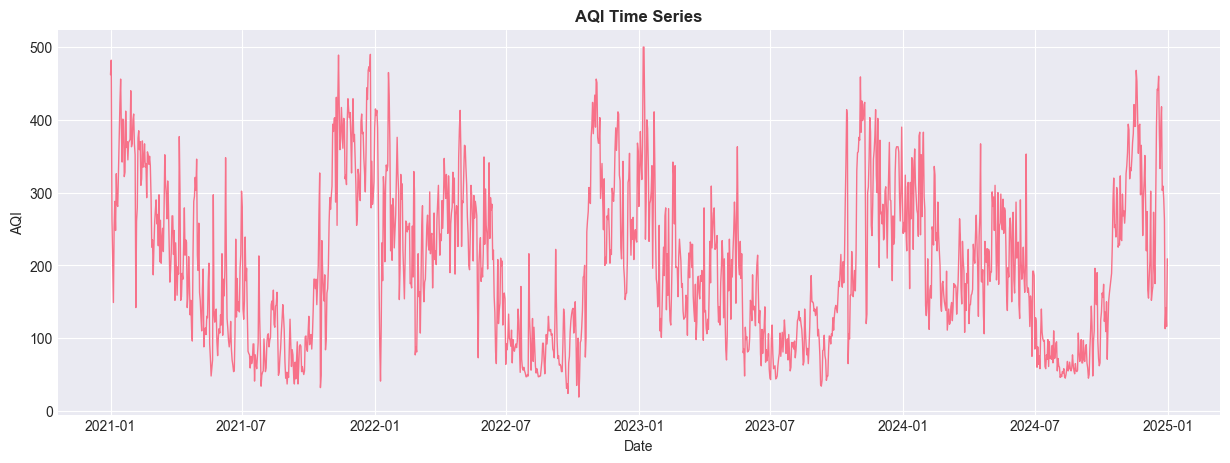

In [3]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df["AQI"], linewidth=1)
plt.title("AQI Time Series", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.savefig('aqi-time-series.png')
plt.show()

Outliers detected: 0 (0.00%)


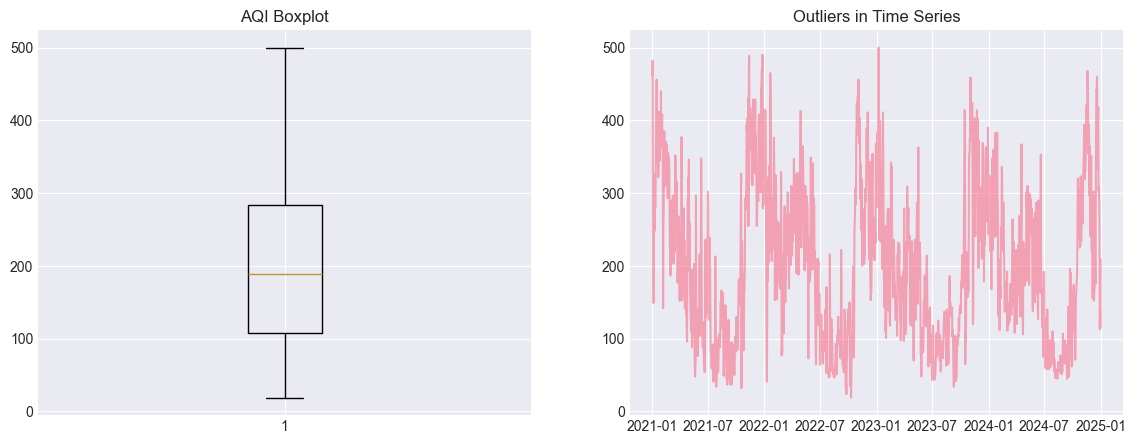

In [4]:
# outlier detection

Q1, Q3 = df["AQI"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

z_scores = np.abs(stats.zscore(df["AQI"]))
outliers = (df["AQI"] < lower) | (df["AQI"] > upper) | (z_scores > 3)

print(f"Outliers detected: {outliers.sum()} ({outliers.mean()*100:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].boxplot(df["AQI"])
axes[0].set_title("AQI Boxplot")

axes[1].plot(df.index, df["AQI"], alpha=0.6)
axes[1].scatter(df.index[outliers], df["AQI"][outliers], color="red", s=15)
axes[1].set_title("Outliers in Time Series")

plt.savefig('outlier-detect.png')
plt.show()

In [5]:
df["AQI"] = np.clip(df["AQI"], lower, upper)

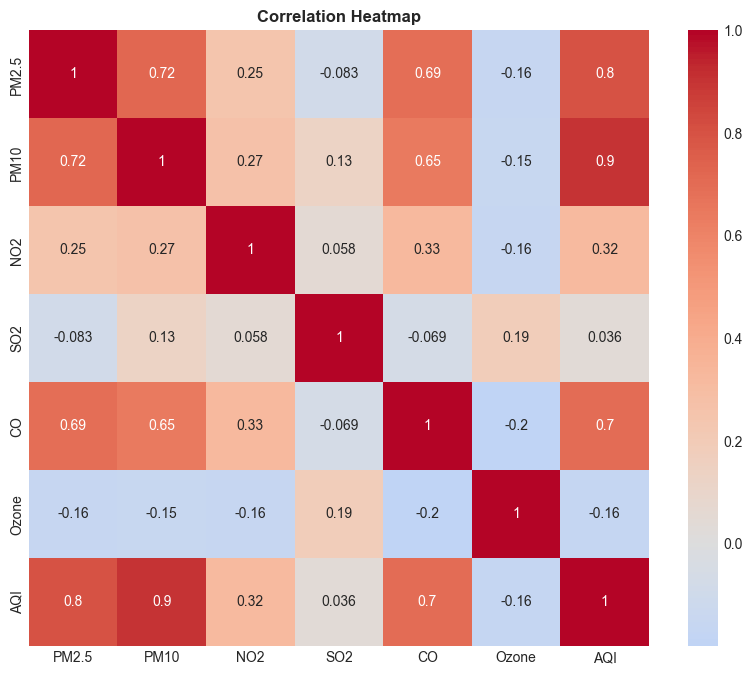

In [6]:
pollutants = ["PM2.5", "PM10", "NO2", "SO2", "CO", "Ozone", "AQI"]
corr = df[pollutants].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap", fontweight="bold")
plt.savefig('heatmap.png')
plt.show()

In [8]:
series = df["AQI"]

test_size = 90
val_size = 60

train = series[:-test_size-val_size]
val = series[-test_size-val_size:-test_size]
test = series[-test_size:]

print(len(train), len(val), len(test))

1311 60 90


### Statistical Data Analysis

In [9]:
adf_p = adfuller(train)[1]
d = 0 if adf_p < 0.05 else 1

print(f"ADF p-value = {adf_p:.4f} → d = {d}")

ADF p-value = 0.0010 → d = 0



 SEASONALITY TESTS
--------------------------------------------------------------------------------


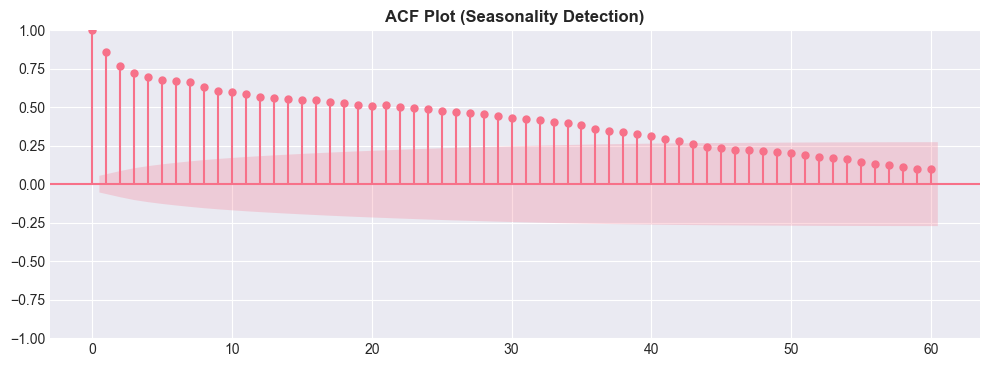

Rule of thumb:
• Significant spikes at lag 7 → weekly seasonality
• Significant spikes at lag 30 → monthly seasonality

Kruskal–Wallis Test (Weekly Seasonality):
Statistic: 0.3863
p-value: 0.9990
✗ No strong weekly seasonality detected

 AUTOCORRELATION TESTS - Ljungbox
------------------------------------------------------------------------------------------
         lb_stat  lb_pvalue
10   6314.352915        0.0
20  10250.211052        0.0
30  13263.643854        0.0
✓ Autocorrelation detected → AR / SARIMA justified

 RANDOM WALK TEST - Augmented Dicker Fuller
------------------------------------------------------------------------------------------
ADF p-value on ΔAQI: 0.0000
✗ Not a random walk (already stationary)

 HETEROSCEDASTICITY TESTS - Rolling Standard Deviation
------------------------------------------------------------------------------------------


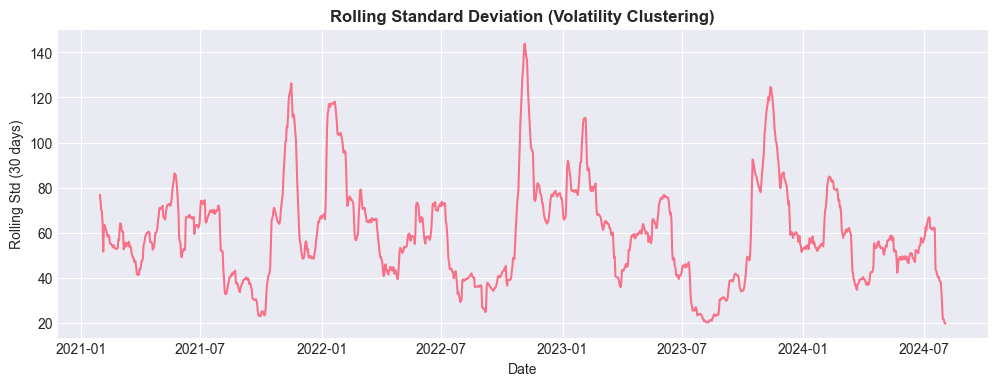

In [10]:
print("\n SEASONALITY TESTS")
print("-" * 80)

fig, ax = plt.subplots(figsize=(12,4))
plot_acf(train, lags=60, ax=ax)
ax.set_title("ACF Plot (Seasonality Detection)", fontweight="bold")
plt.show()

print("Rule of thumb:")
print("• Significant spikes at lag 7 → weekly seasonality")
print("• Significant spikes at lag 30 → monthly seasonality")
train_df = train.to_frame(name="AQI")
train_df["weekday"] = train_df.index.dayofweek

groups = [group["AQI"].values for _, group in train_df.groupby("weekday")]

kw_stat, kw_p = stats.kruskal(*groups)

print("\nKruskal–Wallis Test (Weekly Seasonality):")
print(f"Statistic: {kw_stat:.4f}")
print(f"p-value: {kw_p:.4f}")

if kw_p < 0.05:
    print("✓ Significant WEEKLY seasonality detected")
else:
    print("✗ No strong weekly seasonality detected")
print("\n AUTOCORRELATION TESTS - Ljungbox")
print("-" * 90)

lb = acorr_ljungbox(train, lags=[10, 20, 30], return_df=True)
print(lb)

if (lb["lb_pvalue"] < 0.05).any():
    print("✓ Autocorrelation detected → AR / SARIMA justified")
else:
    print("✗ No significant autocorrelation")
print("\n RANDOM WALK TEST - Augmented Dicker Fuller")
print("-" * 90)

adf_diff_p = adfuller(train.diff().dropna())[1]

print(f"ADF p-value on ΔAQI: {adf_diff_p:.4f}")

if adf_p > 0.05 and adf_diff_p < 0.05:
    print("✓ Strong evidence of RANDOM WALK")
elif adf_p < 0.05:
    print("✗ Not a random walk (already stationary)")
else:
    print("⚠ Inconclusive random walk behavior")
print("\n HETEROSCEDASTICITY TESTS - Rolling Standard Deviation")
print("-" * 90)

rolling_std = train.rolling(30).std()

plt.figure(figsize=(12,4))
plt.plot(rolling_std)
plt.title("Rolling Standard Deviation (Volatility Clustering)", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Rolling Std (30 days)")
plt.savefig('Rolling-Std.png')
plt.show()

## Deep Learning Models - LSTM & GRU

In [12]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()

train_scaled = y_scaler.fit_transform(train.values.reshape(-1, 1))
val_scaled   = y_scaler.transform(val.values.reshape(-1, 1))
test_scaled  = y_scaler.transform(test.values.reshape(-1, 1))

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

def create_val_sequences(train, val, seq_len):
    combined = np.vstack([train[-seq_len:], val])
    return create_sequences(combined, seq_len)

def create_test_sequences(train, val, test, seq_len):
    combined = np.vstack([val[-seq_len:], test])
    return create_sequences(combined, seq_len)

SEQ_LEN = 30
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_val, y_val = create_val_sequences(train_scaled, val_scaled, SEQ_LEN)
X_test, y_test = create_test_sequences(train_scaled, val_scaled, test_scaled, SEQ_LEN)

Epoch 1/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0571 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0234 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0201 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0176 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0229 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0168 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0201 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0178 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 9/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0192 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 10/1

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0125 - val_loss: 0.0031 - learning_rate: 1.0000e-05
Epoch 58/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0123 - val_loss: 0.0031 - learning_rate: 1.0000e-05
Epoch 59/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0117 - val_loss: 0.0031 - learning_rate: 1.0000e-06
Epoch 60/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0127 - val_loss: 0.0031 - learning_rate: 1.0000e-06
Epoch 61/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0127 - val_loss: 0.0031 - learning_rate: 1.0000e-06
Epoch 62/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0121 - val_loss: 0.0031 - learning_rate: 1.0000e-06
Epoch 63/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0128 - val_loss: 0.0031 - learning_rate: 1.0000e-06
Epoch 64/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0122 - val_loss: 0.0031 - learning_rate: 1.0000e-06
Epoch 65/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0127 - val_loss: 0.0031 - lear

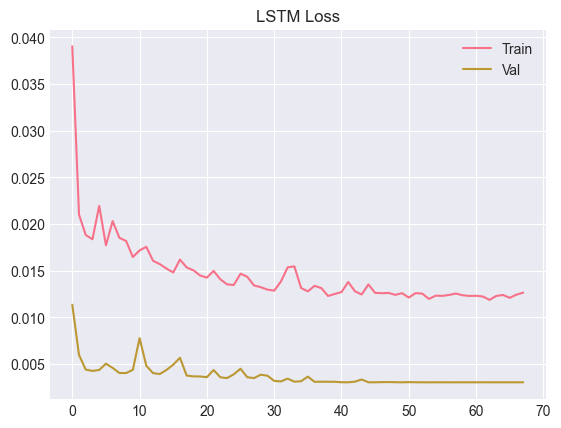

In [14]:
def build_lstm(units, dropout, lr):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(SEQ_LEN,1)),
        Dropout(dropout),
        LSTM(units),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(lr), loss="mse")
    return model

lstm = build_lstm(128, 0.2, 0.001)

callbacks = [
    EarlyStopping(patience=18, restore_best_weights=True),
    ReduceLROnPlateau(patience=7)
]

history = lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("LSTM Loss")
plt.legend()
plt.savefig('lstm.png')
plt.show()

Epoch 1/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0721 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0185 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0149 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0167 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0143 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0143 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0138 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0133 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 9/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0132 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 10/1

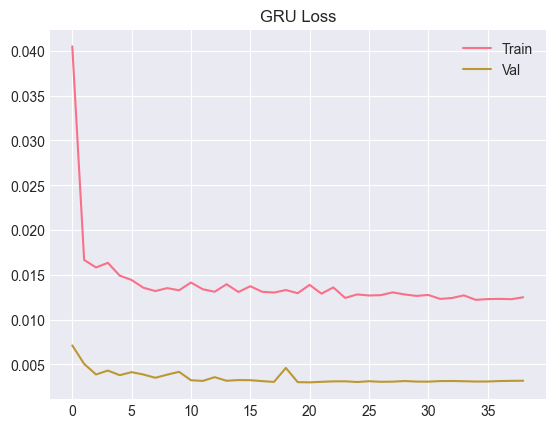

In [15]:
def build_gru(units, dropout, lr):
    model = Sequential([
        GRU(units, return_sequences=True, input_shape=(SEQ_LEN,1)),
        Dropout(dropout),
        GRU(units),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(lr), loss="mse")
    return model

gru = build_gru(128, 0.2, 0.001)

callbacks = [
    EarlyStopping(patience=18, restore_best_weights=True),
    ReduceLROnPlateau(patience=7)
]
history = gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("GRU Loss")
plt.legend()
plt.savefig("gru_loss.png")
plt.show()

In [16]:
lstm_pred_scaled = lstm.predict(X_test)
lstm_pred = y_scaler.inverse_transform(lstm_pred_scaled).flatten()

gru_pred_scaled = gru.predict(X_test)
gru_pred = y_scaler.inverse_transform(gru_pred_scaled).flatten()

# Ground truth
y_test_true = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

print(lstm_pred.shape)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
(90,)


## Time Series Modelling

In [17]:
print("\n ARIMA SELECTION (Normalized AIC + BIC)")
print("-" * 60)

results = []

for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        try:
            model = ARIMA(
                train,
                order=(p, d, q),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fit = model.fit()

            if np.isfinite(fit.aic) and np.isfinite(fit.bic):
                results.append({
                    "order": (p, d, q),
                    "aic": fit.aic,
                    "bic": fit.bic
                })

        except Exception:
            continue

# Fallback
if len(results) == 0:
    print("⚠ All ARIMA fits failed — using fallback ARIMA(1,d,1)")
    best_params = (1, d, 1)

else:
    aics = np.array([r["aic"] for r in results])
    bics = np.array([r["bic"] for r in results])

    # Safe normalization
    aic_range = aics.max() - aics.min()
    bic_range = bics.max() - bics.min()

    aic_norm = (aics - aics.min()) / aic_range if aic_range > 0 else np.zeros_like(aics)
    bic_norm = (bics - bics.min()) / bic_range if bic_range > 0 else np.zeros_like(bics)

    combined_score = aic_norm + bic_norm
    best_idx = np.argmin(combined_score)

    best_params = results[best_idx]["order"]

    print(f"✓ Selected ARIMA order: {best_params}")
    print(f"  AIC: {results[best_idx]['aic']:.2f}")
    print(f"  BIC: {results[best_idx]['bic']:.2f}")
    print(f"  Normalized score: {combined_score[best_idx]:.4f}")


 ARIMA SELECTION (Normalized AIC + BIC)
------------------------------------------------------------


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency inform

C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency inform

C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: M

✓ Selected ARIMA order: (1, 0, 5)
  AIC: 14020.11
  BIC: 14061.50
  Normalized score: 0.0001


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



ARIMA Forecast (first 10 values):
2024-08-04     73.788902
2024-08-05     82.214716
2024-08-06     86.869907
2024-08-07     90.033540
2024-08-08     92.511868
2024-08-09     94.519694
2024-08-10     96.490940
2024-08-11     98.426275
2024-08-12    100.326351
2024-08-13    102.191811
Freq: D, Name: predicted_mean, dtype: float64


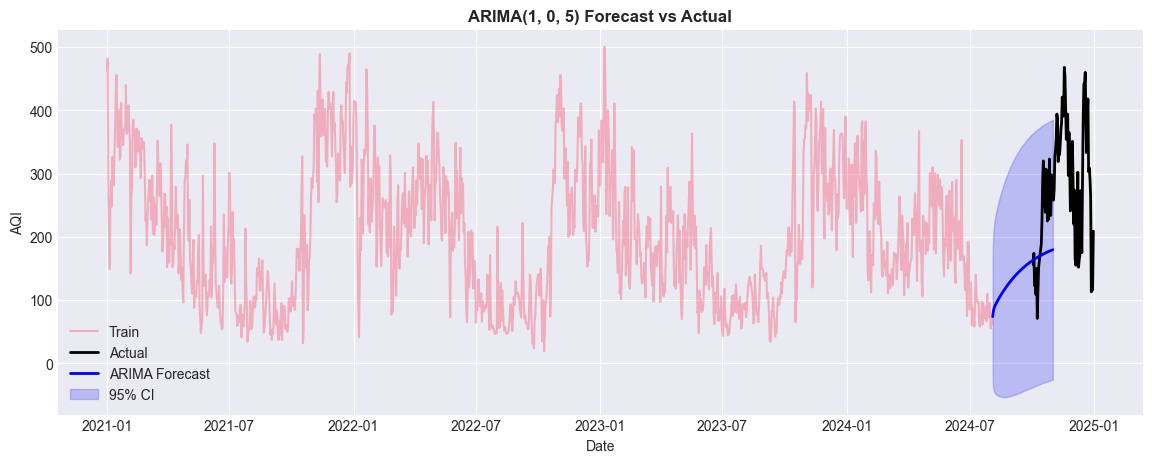

In [18]:
arima_model = ARIMA(
    train,
    order=best_params,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

arima_forecast = arima_model.get_forecast(len(test)).predicted_mean
print("\nARIMA Forecast (first 10 values):")
print(arima_forecast.head(10))

plt.figure(figsize=(14,5))
arima_fc_obj = arima_model.get_forecast(steps=len(test))
arima_forecast = arima_fc_obj.predicted_mean
arima_ci = arima_fc_obj.conf_int()
arima_pred = arima_fc_obj.predicted_mean.values
plt.plot(train.index, train, label="Train", alpha=0.5)
plt.plot(test.index, test, label="Actual", color="black", linewidth=2)

plt.plot(arima_forecast.index, arima_forecast,
         label="ARIMA Forecast", color="blue", linewidth=2)

plt.fill_between(
    arima_forecast.index,
    arima_ci.iloc[:, 0],
    arima_ci.iloc[:, 1],
    color="blue",
    alpha=0.2,
    label="95% CI"
)

plt.title(f"ARIMA{best_params} Forecast vs Actual", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.savefig("arima.png")
plt.show()

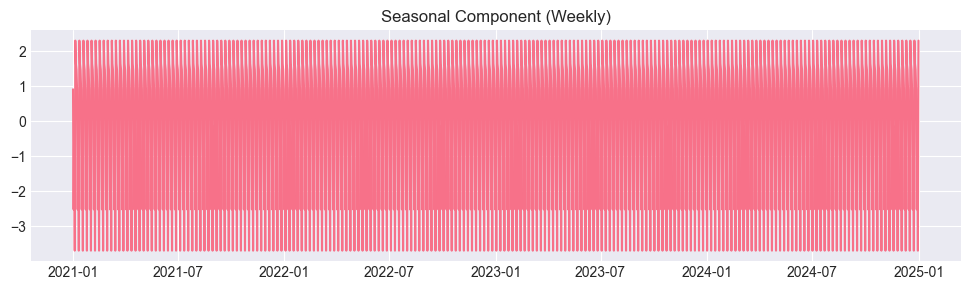

Seasonality strength: 0.020


In [19]:
series = df["AQI"].asfreq("D")
series = series.ffill()
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_period = 7  # weekly for daily AQI
decomp = seasonal_decompose(series, period=seasonal_period, model="additive")

plt.figure(figsize=(12,3))
plt.plot(decomp.seasonal)
plt.title("Seasonal Component (Weekly)")
plt.savefig("seasonal-component.png")
plt.show()

seasonality_strength = decomp.seasonal.std() / series.std()
print(f"Seasonality strength: {seasonality_strength:.3f}")
D = 1 if seasonality_strength > 0.05 else 0

In [32]:
train_log = np.log1p(train)

results = []

# ------------------------------------------------
# 2. Grid search (LOG SCALE)
# ------------------------------------------------
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        try:
            model = SARIMAX(
                train_log,
                order=(p, d, q),
                seasonal_order=(1, D, 1, seasonal_period),
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            fit = model.fit(disp=False)

            if np.isfinite(fit.aic) and np.isfinite(fit.bic):
                results.append({
                    "order": (p, d, q),
                    "seasonal": (1, D, 1, seasonal_period),
                    "aic": fit.aic,
                    "bic": fit.bic
                })

        except Exception:
            continue

# ------------------------------------------------
# 3. Select best model
# ------------------------------------------------
if not results:
    print("⚠ All SARIMA fits failed — using fallback SARIMA(1,d,1)x(1,D,1,s)")
    best_order = (1, d, 1)
    best_seasonal = (1, D, 1, seasonal_period)

else:
    aics = np.array([r["aic"] for r in results])
    bics = np.array([r["bic"] for r in results])

    aic_range = aics.max() - aics.min()
    bic_range = bics.max() - bics.min()

    aic_norm = (aics - aics.min()) / aic_range if aic_range > 0 else np.zeros_like(aics)
    bic_norm = (bics - bics.min()) / bic_range if bic_range > 0 else np.zeros_like(bics)

    combined_score = aic_norm + bic_norm
    best_idx = np.argmin(combined_score)

    best_order = results[best_idx]["order"]
    best_seasonal = results[best_idx]["seasonal"]

    print(f"✓ Selected SARIMA model: {best_order} x {best_seasonal}")
    print(f"  AIC: {results[best_idx]['aic']:.2f}")
    print(f"  BIC: {results[best_idx]['bic']:.2f}")
    print(f"  Normalized score: {combined_score[best_idx]:.4f}")

✓ Selected SARIMA model: (2, 0, 1) x (1, 1, 1, 7)
  AIC: 544.24
  BIC: 575.24
  Normalized score: 0.0000


                                     SARIMAX Results                                     
Dep. Variable:                               AQI   No. Observations:                 1311
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 7)   Log Likelihood                -266.120
Date:                           Tue, 23 Dec 2025   AIC                            544.239
Time:                                   16:25:16   BIC                            575.237
Sample:                               01-01-2021   HQIC                           555.872
                                    - 08-03-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5514      0.036     43.249      0.000       1.481       1.622
ar.L2         -0.5580      0.034    -16.299

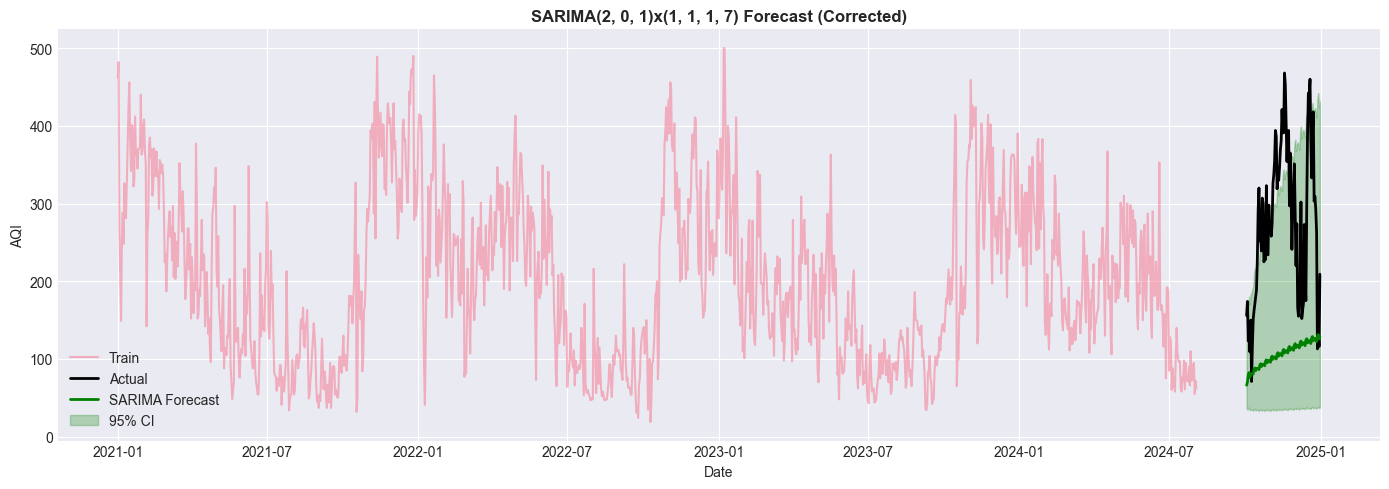

In [33]:
sarima_model = SARIMAX(
    train_log,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarima_model.summary())

# ------------------------------------------------
# 5. Forecast (LOG → INVERT)
# ------------------------------------------------
sarima_fc = sarima_model.get_forecast(steps=len(test))

sarima_forecast = np.expm1(sarima_fc.predicted_mean)
sarima_ci = np.expm1(sarima_fc.conf_int())

sarima_forecast.index = test.index
sarima_ci.index = test.index
plt.figure(figsize=(14, 5))

plt.plot(train.index, train, label="Train", alpha=0.5)
plt.plot(test.index, test, label="Actual", color="black", linewidth=2)

plt.plot(
    sarima_forecast.index,
    sarima_forecast,
    label="SARIMA Forecast",
    color="green",
    linewidth=2
)

plt.fill_between(
    sarima_ci.index,
    sarima_ci.iloc[:, 0],
    sarima_ci.iloc[:, 1],
    color="green",
    alpha=0.25,
    label="95% CI"
)

plt.title(f"SARIMA{best_order}x{best_seasonal} Forecast (Corrected)", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.savefig("sarima.png")
plt.show()


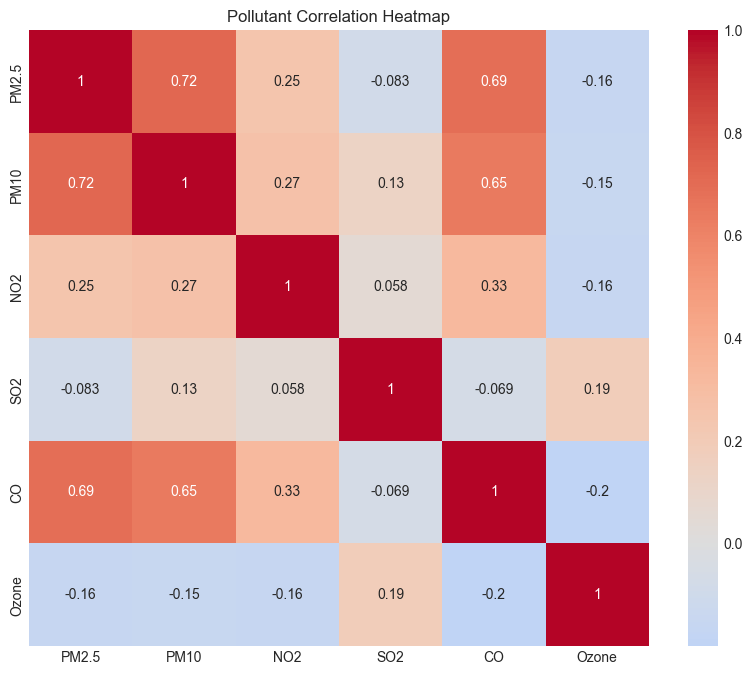

In [22]:
exog_cols = ["PM2.5", "PM10", "NO2", "SO2", "CO", "Ozone"]
df_exog = df[exog_cols].asfreq("D").ffill()
series = df["AQI"].asfreq("D").ffill()
exog_train = df_exog.loc[train.index]
exog_train = exog_train.fillna(method="ffill").fillna(method="bfill")
exog_test  = df_exog.loc[test.index]
plt.figure(figsize=(10,8))
sns.heatmap(df_exog.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Pollutant Correlation Heatmap")
plt.show()

In [29]:
exog_cols = ["PM2.5", "PM10", "NO2", "SO2", "CO", "Ozone"]
seasonal_period = 7
D = 1

print("\n SARIMAX SELECTION WITH POLLUTANTS (FIXED & CONSISTENT)")
print("-" * 60)

exog_train = exog_train.loc[train.index, exog_cols]
exog_test  = exog_test.loc[test.index, exog_cols]

exog_train = exog_train.ffill().bfill()
exog_test  = exog_test.ffill().bfill()

scaler = StandardScaler()
exog_train_scaled = pd.DataFrame(
    scaler.fit_transform(exog_train),
    index=exog_train.index,
    columns=exog_train.columns
)

exog_test_scaled = pd.DataFrame(
    scaler.transform(exog_test),
    index=exog_test.index,
    columns=exog_test.columns
)

train_log = np.log1p(train)

results = []

for p in range(4):
    for q in range(4):
        try:
            model = SARIMAX(
                train_log,
                exog=exog_train_scaled,
                order=(p, d, q),
                seasonal_order=(1, D, 1, seasonal_period),
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            fit = model.fit(disp=False)

            if np.isfinite(fit.aic) and np.isfinite(fit.bic):
                results.append({
                    "order": (p, d, q),
                    "seasonal": (1, D, 1, seasonal_period),
                    "aic": fit.aic,
                    "bic": fit.bic
                })

        except Exception:
            continue


if not results:
    print("⚠ All fits failed — using fallback")
    best_order = (1, d, 1)
    best_seasonal = (1, D, 1, seasonal_period)
else:
    aics = np.array([r["aic"] for r in results])
    bics = np.array([r["bic"] for r in results])

    aic_norm = (aics - aics.min()) / (aics.max() - aics.min())
    bic_norm = (bics - bics.min()) / (bics.max() - bics.min())

    combined = aic_norm + bic_norm
    best = results[np.argmin(combined)]

    best_order = best["order"]
    best_seasonal = best["seasonal"]

    print(f"✓ Selected SARIMAX {best_order} x {best_seasonal}")
    print(f"  AIC: {best['aic']:.2f}")
    print(f"  BIC: {best['bic']:.2f}")


 SARIMAX SELECTION WITH POLLUTANTS (FIXED & CONSISTENT)
------------------------------------------------------------
✓ Selected SARIMAX (3, 0, 1) x (1, 1, 1, 7)
  AIC: -112.36
  BIC: -45.21


                                     SARIMAX Results                                     
Dep. Variable:                               AQI   No. Observations:                 1311
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 7)   Log Likelihood                  17.798
Date:                           Tue, 23 Dec 2025   AIC                            -11.596
Time:                                   16:25:39   BIC                             50.399
Sample:                               01-01-2021   HQIC                            11.669
                                    - 08-03-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PM2.5          0.0404      0.006      6.778      0.000       0.029       0.052
PM10           0.2898      0.009     32.811

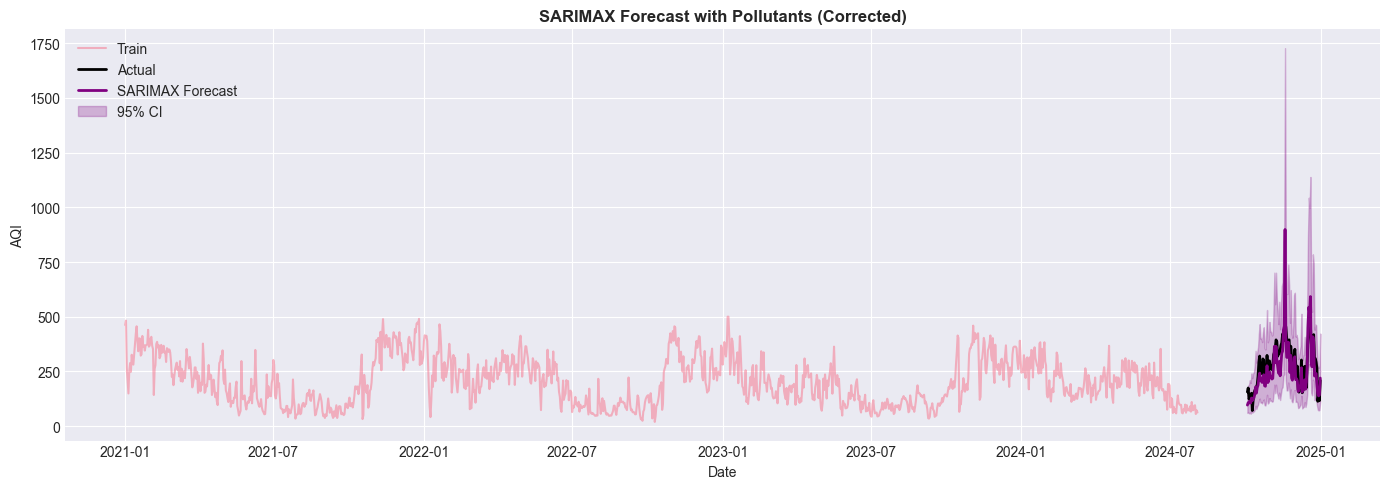

In [34]:
sarimax_model = SARIMAX(
    train_log,
    exog=exog_train_scaled,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarimax_model.summary())
sarimax_fc = sarimax_model.get_forecast(
    steps=len(test),
    exog=exog_test_scaled
)

sarimax_forecast = np.expm1(sarimax_fc.predicted_mean)
sarimax_ci = np.expm1(sarimax_fc.conf_int())

sarimax_forecast.index = test.index
sarimax_ci.index = test.index
plt.figure(figsize=(14, 5))

plt.plot(train.index, train, label="Train", alpha=0.5)
plt.plot(test.index, test, label="Actual", color="black", linewidth=2)

plt.plot(
    sarimax_forecast.index,
    sarimax_forecast,
    label="SARIMAX Forecast",
    color="purple",
    linewidth=2
)

plt.fill_between(
    sarimax_ci.index,
    sarimax_ci.iloc[:, 0],
    sarimax_ci.iloc[:, 1],
    color="purple",
    alpha=0.25,
    label="95% CI"
)

plt.title("SARIMAX Forecast with Pollutants (Corrected)", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.savefig("sarimax.png")
plt.show()

In [35]:
sarimax_rmse = np.sqrt(mean_squared_error(test, sarimax_forecast))
sarimax_mae  = mean_absolute_error(test, sarimax_forecast)
sarimax_r2   = r2_score(test, sarimax_forecast)

coef = sarimax_model.params
conf = sarimax_model.conf_int()

pollutant_effects = pd.DataFrame({
    "Coefficient": coef[exog_cols],
    "Lower CI": conf.loc[exog_cols, 0],
    "Upper CI": conf.loc[exog_cols, 1]
})

print("\nPollutant Effects on AQI:")
print(pollutant_effects.sort_values("Coefficient", ascending=False))


Pollutant Effects on AQI:
       Coefficient  Lower CI  Upper CI
PM10      0.289789  0.272478  0.307099
Ozone     0.049225  0.030079  0.068371
NO2       0.042366  0.023971  0.060761
PM2.5     0.040380  0.028704  0.052056
CO        0.034957  0.017989  0.051925
SO2       0.006777 -0.028327  0.041882


#### Results

In [36]:
arima_pred  = np.array(arima_forecast).flatten()
sarima_pred = np.array(sarima_pred).flatten()
sarimax_pred = np.array(sarimax_forecast).flatten()

In [37]:
models = {
    "LSTM": lstm_pred,
    "GRU": gru_pred,
    "ARIMA": arima_pred,
    "SARIMA": sarima_pred,
    "SARIMAX": sarimax_pred
}

In [38]:
seq_len = SEQ_LEN

# Common evaluation window (drop first seq_len points)
test_eval = test.iloc[seq_len:].values

# --- Deep Learning models (already length = len(test) - seq_len)
lstm_pred_eval = lstm_pred[seq_len:]
gru_pred_eval  = gru_pred[seq_len:]

# --- Statistical models (trim to match DL horizon)
arima_pred_eval   = arima_pred[seq_len:]
sarima_pred_eval  = sarima_pred[seq_len:]
sarimax_pred_eval = sarimax_pred[seq_len:]

# Final safety check
print("Lengths after alignment:")
print("Test:", len(test_eval))
print("LSTM:", len(lstm_pred_eval))
print("GRU:", len(gru_pred_eval))
print("ARIMA:", len(arima_pred_eval))
print("SARIMA:", len(sarima_pred_eval))
print("SARIMAX:", len(sarimax_pred_eval))

Lengths after alignment:
Test: 60
LSTM: 60
GRU: 60
ARIMA: 60
SARIMA: 60
SARIMAX: 60


#### Metrics

In [39]:
def mase(y_true, y_pred, y_train, s=7):
    naive = np.abs(y_train[s:] - y_train[:-s]).mean()
    return (np.mean(np.abs(y_true - y_pred)) / naive)/100

models = {
    "LSTM": lstm_pred_eval,
    "GRU": gru_pred_eval,
    "ARIMA": arima_pred_eval,
    "SARIMA": sarima_pred_eval,
    "SARIMAX": sarimax_pred_eval
}

results = []

for name, pred in models.items():
    results.append({
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(test_eval, pred))/100,
        "MAE": mean_absolute_error(test_eval, pred)/100,
        "MASE": mase(test_eval, pred, train.values)
    })

results_df = pd.DataFrame(results).sort_values("RMSE")

print("\nMODEL COMPARISON (ALIGNED HORIZON):")
print(results_df.to_string(index=False))


MODEL COMPARISON (ALIGNED HORIZON):
  Model     RMSE      MAE     MASE
   LSTM 0.609367 0.497716 0.007544
    GRU 0.653973 0.537019 0.008140
SARIMAX 0.792467 0.540407 0.008192
  ARIMA 1.769939 1.536504 0.023290
 SARIMA 2.657334 2.493408 0.037795


#### Final Forecast


Best 3 model(s): ['LSTM' 'GRU' 'SARIMAX']


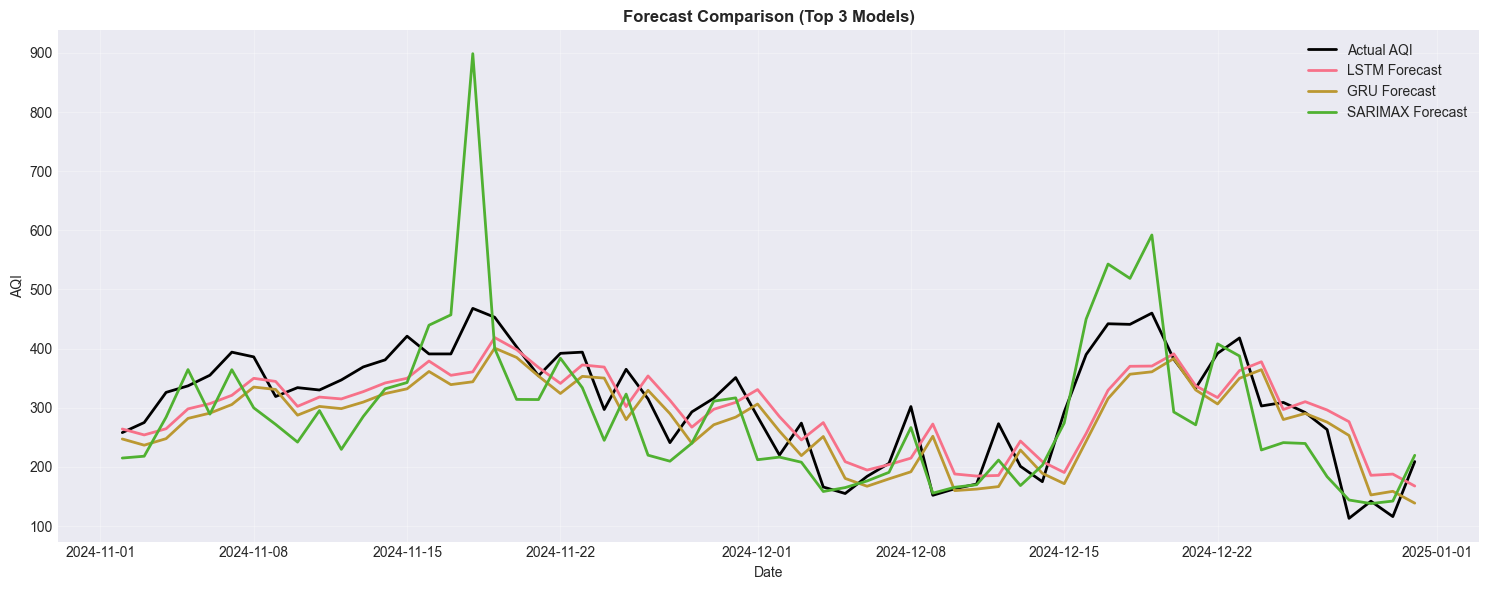

In [41]:
TOP_N = 3

# Get best models
best_models = results_df.head(TOP_N)["Model"].values

print(f"\nBest {TOP_N} model(s):", best_models)

# Create aligned date index
forecast_dates = test.index[seq_len:]

# Map model names to aligned predictions
pred_map = {
    "LSTM": lstm_pred_eval,
    "GRU": gru_pred_eval,
    "ARIMA": arima_pred_eval,
    "SARIMA": sarima_pred_eval,
    "SARIMAX": sarimax_pred_eval
}


plt.figure(figsize=(15, 6))
plt.plot(
    forecast_dates,
    test_eval,
    label="Actual AQI",
    color="black",
    linewidth=2
)

for model_name in best_models:
    plt.plot(
        forecast_dates,
        pred_map[model_name],
        label=f"{model_name} Forecast",
        linewidth=2
    )

plt.title(
    f"Forecast Comparison (Top {TOP_N} Model{'s' if TOP_N > 1 else ''})",
    fontweight="bold"
)
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("forecast.png")
plt.show()